In [1]:
from collections import Counter
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import importlib
import random
import time
import csv

from Project.utils.objects import youtube
from Project.utils.storage import youtube_db as db
from Project.utils.analysis import text_classifier as tc

importlib.reload(tc)
importlib.reload(db)
importlib.reload(youtube)

C:\Users\Filippo Corti\miniconda3\envs\SocialMediaMining\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


<module 'Project.utils.objects.youtube' from 'C:\\Users\\Filippo Corti\\Documents\\GitHub\\SocialMediaMining\\Project\\utils\\objects\\youtube.py'>

In [2]:
trump_podcasts = [
    "xrFdHO7FH8w",
    "blqIZGXWUpU",
    "s11uIW7wi-E",
    "vC5cHjcgt5g",
    "G80iLTctFuY",
    "qCbfTN-caFI",
    "Ry1IjOft95c",
    "S7BTdUaNQM8",
    "1SsmPh8gCxU",
    "-dmwG54QsKc",
    "nwQil7tcImI",
    "G9lXnwuZ2qs",
    "hBMoPUAeLnY"
]

harris_podcasts = [
    "_KCRsjPCiCI",
    "bzThwqnQJDY",
    "7L4sts7I3xI",
    "pNbwMrBMGgE",
    "Vu5yD3fu6A8",
]

youtube_db = db.SQLiteYoutubeSaver()

text_classifier = tc.TextClassifier()

In [3]:
Youtube_Graph = youtube_db.extract_network()

# Add podcast_guest attribute
for node, data in Youtube_Graph.nodes(data=True):
    video_id = data.get('most_commented_video_id')
    if video_id in trump_podcasts:
        Youtube_Graph.nodes[node]['podcast_guest'] = 'Trump'
    else:
        Youtube_Graph.nodes[node]['podcast_guest'] = 'Harris'

#nx.write_gexf(Youtube_Graph, "youtube.gexf")

# Youtube_Graph = nx.read_gexf("data/youtube.gexf")

In [13]:
def gini_coeff(x):
    x = np.sort(np.array(x))
    n = len(x)
    cumx = np.cumsum(x)
    return (n + 1 - 2 * np.sum(cumx) / cumx[-1]) / n

def analyze_graph(G, color):
    print(f"{G.order()} Nodes and {G.size()} Edges")
    print(f"Density is {nx.density(G)}")

    degree = dict(G.degree())
    in_degree = dict(G.in_degree())
    out_degree = dict(G.out_degree())
    degree_values = list(degree.values())
    in_degree_values = list(in_degree.values())
    out_degree_values = list(out_degree.values())

    # Calculate Lorenz Curve for the Distribution of Posts between Users
    posts_count_dict = np.sort([
        node['comments_count']
        for node_id, node in G.nodes(data=True)
    ])
    posts_count_cdf = np.cumsum(posts_count_dict) / sum(posts_count_dict)
    lam = nx.density(G) * (G.order() - 1)
    poisson_posts_count = np.sort(np.random.poisson(lam=lam, size=len(posts_count_dict)))
    poisson_posts_count_cdf = np.cumsum(poisson_posts_count) / sum(poisson_posts_count)


    count, bins = np.histogram(
        in_degree_values,
        bins=np.arange(0, max(in_degree_values) + 2)
    )
    pdf = count / G.order()
    ccdf = 1.0 - np.cumsum(pdf)

    ccdf[-1] = 0.0 # Fixes floating point error

    print(f"Nodes with in degree zero: {len([x for x in in_degree_values if x == 0])}")

    # Compute connected component sizes
    cc = list(nx.weakly_connected_components(G))
    component_sizes = sorted([len(c) for c in cc], reverse=True)
    components_by_size = Counter(component_sizes)

    # Print stats
    print(f"Min Degree: {min(degree_values)}")
    print(f"Max Degree: {max(degree_values)}")
    print(f"Average Degree: {np.mean(degree_values):.2f}")
    print(f"Average In-Degree: {np.mean(in_degree_values):.2f}")
    print(f"Average Out-Degree: {np.mean(out_degree_values):.2f}")

    print(f"There are {len(cc)} Connected Components:")
    for component in cc[:min(3, len(cc))]:
        print(f"\tConnected Component of size: {len(component)} ({len(component)/G.order():.2%})")
    print("\t...")

    top_in = sorted(in_degree.items(), key=lambda x: x[1], reverse=True)[:3]
    print("Top 3 Nodes by In-Degree:")
    for node, deg in top_in:
        attrs = G.nodes(data=True)[node]
        print(f"\tNode {attrs['username']} {attrs['url']}: In-Degree = {deg}")

    top_out = sorted(out_degree.items(), key=lambda x: x[1], reverse=True)[:3]
    print("Top 3 Nodes by Out-Degree:")
    for node, deg in top_out:
        attrs = G.nodes(data=True)[node]
        print(f"\tNode {attrs['username']} {attrs['url']}: Out-Degree = {deg}")

    # Degree Centrality
    deg_centrality = nx.degree_centrality(G)
    top_deg_centrality = sorted(deg_centrality.items(), key=lambda x: x[1], reverse=True)[:3]
    print("Top 3 Nodes by Degree Centrality:")
    for node, centrality in top_deg_centrality:
        attrs = G.nodes(data=True)[node]
        print(f"\tNode {attrs['username']} {attrs['url']}: Degree Centrality = {centrality:.4f}")


    plt.figure(figsize=(7, 4))
    plt.plot(bins[:-1], pdf, marker='o', linestyle='--', label="Degree PDF", color=color)
    #plt.xscale("log")
    #plt.yscale("log")
    plt.title("In-Degree PDF")
    plt.xlabel("Degree")
    plt.ylabel("PDF - P(X=x)")
    plt.grid()
    plt.show()

    plt.figure(figsize=(7, 4))
    plt.plot(bins[:-2], ccdf[:-1], marker='o', linestyle='--', label="Degree CCDF", color=color)
    plt.xscale("log")
    plt.yscale("log")
    plt.title("In-Degree CCDF")
    plt.xlabel("Degree")
    plt.ylabel("CCDF - P(X>x)")
    plt.grid()
    plt.show()

    plt.figure(figsize=(7, 4))
    plt.scatter(np.arange(len(posts_count_cdf)) / (len(posts_count_dict) - 1), posts_count_cdf, marker='o', linestyle='--', label="Network", color=color)
    plt.scatter(np.arange(len(poisson_posts_count_cdf)) / (len(poisson_posts_count) - 1), poisson_posts_count_cdf, marker='o', linestyle='--', label="Erdos-Renyi Random Network", color="gray")
    plt.plot([0, 1], [0, 1], 'k--', label="Equality Line")
    plt.title("Lorenz Curve of Posts per User")
    plt.xlabel("Cum. % of Users")
    plt.ylabel("Cum. % of Posts")
    plt.legend()
    plt.grid()
    plt.show()

    print(f"Gini Coefficient: {gini_coeff(posts_count_dict):.5f}")

    plt.figure(figsize=(7, 4))
    plt.scatter(list(components_by_size.keys()), list(components_by_size.values()), color=color)
    plt.xscale("log")
    plt.yscale("log")
    plt.title("Weakly Connected Components")
    plt.xlabel("Component Size")
    plt.ylabel("# of Components")
    plt.grid()
    plt.show()

    plt.figure(figsize=(7, 4))
    plt.hist(list(deg_centrality.values()), bins=50, log=True, color=color, alpha=0.7)
    plt.title("Distribuzione Degree Centrality")
    plt.xlabel("Degree Centrality")
    plt.ylabel("Frequency")
    plt.grid()
    plt.show()


58300 Nodes and 97531 Edges
Density is 2.8695448497788227e-05
Nodes with in degree zero: 42179
Min Degree: 1
Max Degree: 691
Average Degree: 3.35
Average In-Degree: 1.67
Average Out-Degree: 1.67
There are 361 Connected Components:
	Connected Component of size: 57278 (98.25%)
	Connected Component of size: 2 (0.00%)
	Connected Component of size: 4 (0.01%)
	...
Top 3 Nodes by In-Degree:
	Node @n2t http://www.youtube.com/@n2t: In-Degree = 691
	Node @huracanian3051 http://www.youtube.com/@huracanian3051: In-Degree = 689
	Node @DisskkonnectxX http://www.youtube.com/@DisskkonnectxX: In-Degree = 682
Top 3 Nodes by Out-Degree:
	Node @H-Town25 http://www.youtube.com/@H-Town25: Out-Degree = 95
	Node @BoolyK http://www.youtube.com/@BoolyK: Out-Degree = 78
	Node @daveonmasolino3336 http://www.youtube.com/@daveonmasolino3336: Out-Degree = 75
Top 3 Nodes by Degree Centrality:
	Node @n2t http://www.youtube.com/@n2t: Degree Centrality = 0.0119
	Node @huracanian3051 http://www.youtube.com/@huracanian305

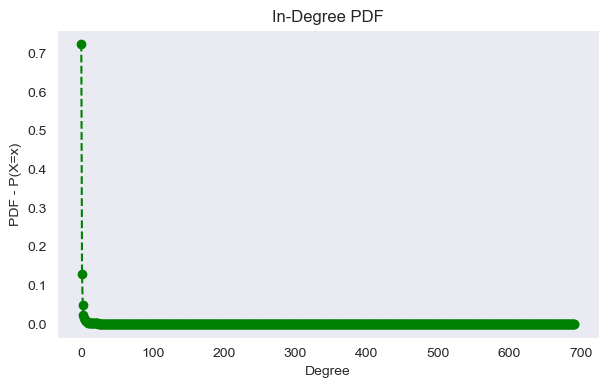

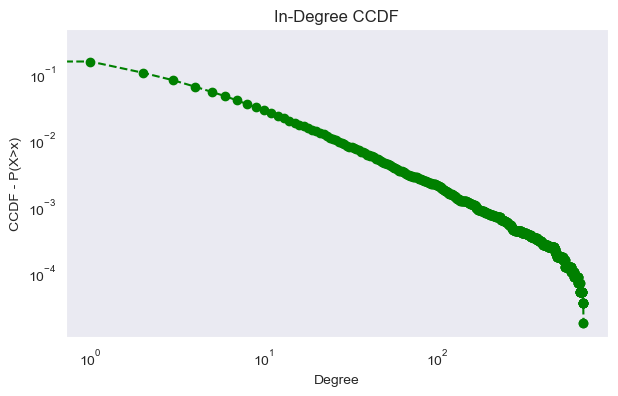

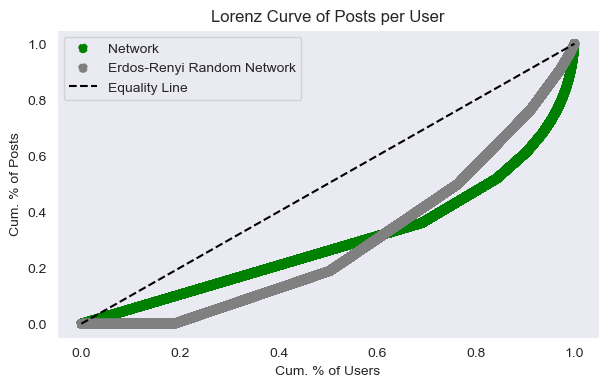

Gini Coefficient: 0.40516


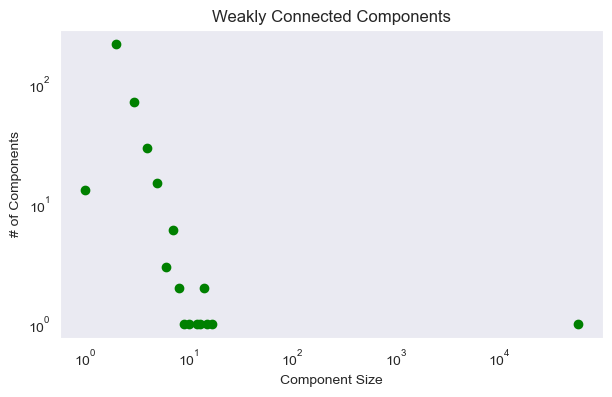

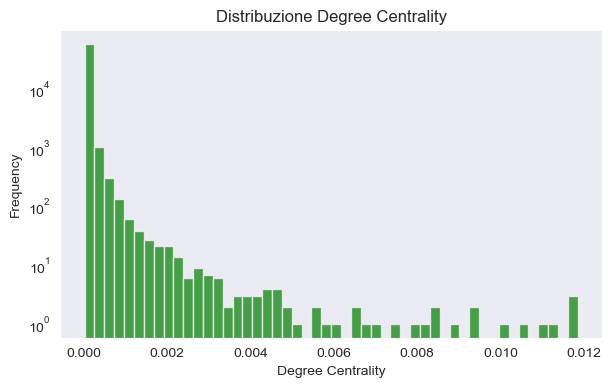

In [14]:
analyze_graph(Youtube_Graph, color="green")

In [4]:
yt_threads = youtube_db.get_threads()


thread_sizes = sorted([t.get_size() for t in yt_threads], reverse=True)
thread_unique_users = sorted([t.get_unique_users() for t in yt_threads], reverse=True)
thread_depths = sorted([t.get_depth() for t in yt_threads], reverse=True)
thread_wieners = sorted([t.get_wiener_index() for t in yt_threads], reverse=True)
thread_cpu = sorted([t.get_comments_per_user() for t in yt_threads], reverse=True)

print(len(yt_threads))
print(thread_sizes[:10])
print(thread_unique_users[:10])
print(thread_depths[:10])
print(thread_wieners[:10])
print(thread_cpu[:10])


# for thread in yt_threads[5:6]:
#     #YTThreadTree.print(thread)
#     print(thread.get_size())
#     print(thread.get_unique_users())
#     print(thread.get_depth())
#     print(thread.get_wiener_index())
#     print(thread.get_normalized_wiener_index())
#     print("------")
#     thread.print()

7200
[787, 777, 777, 762, 757, 755, 754, 754, 753, 753]
[731, 715, 697, 690, 660, 660, 614, 613, 611, 603]
[36, 29, 27, 25, 25, 21, 21, 19, 19, 18]
[1432108.0, 1352822.0, 1237826.0, 1224816.0, 1202126.0, 1076329.0, 1070698.0, 973331.0, 952244.0, 950082.0]
[8.0, 7.0, 4.75, 4.0, 4.0, 3.888888888888889, 3.75, 3.4705882352941178, 3.3333333333333335, 3.0]


In [6]:
print(len([d for d in thread_depths if d == 1]))
print(len([u for u in thread_unique_users if u == 1]))

3401
3415


In [6]:
best_threads = sorted(yt_threads, key=lambda t: t.get_comments_per_user(), reverse=True)[:10]

best_threads[3].print()

- @saeedbiamani2513: '28:56 is my favourite part I can’t stop watching that part it’s hilarious'
  - @donsolos: '😂😂😂😂😂😂😂😂😂\n\nI just made a comment about that too. That ish had me howling!! I pro'
  - @saeedbiamani2513: '@ next she’s gona say she started bloods&crips'
    - @donsolos: '@@saeedbiamani2513 nah she gonna drop a video with the homies showing off her c '
    - @donsolos: '@@saeedbiamani2513 I expect a video any day now to drop of her c walking'
    - @donsolos: '@@saeedbiamani2513 of course youtube deleted my reply to you'
      - @saeedbiamani2513: '@@donsolos 😂😂😂😂😂'
        - @donsolos: "@@saeedbiamani2513 is that your real name? That's a sick name"


In [38]:
import community as community_louvain

partition = community_louvain.best_partition(
    Youtube_Graph.to_undirected(),
    resolution=0.4
)

nx.set_node_attributes(Youtube_Graph, partition, 'community')

In [29]:
num_communities = len(set(partition.values()))

num_communities

439

In [39]:
nx.write_gexf(Youtube_Graph, "youtube.gexf")

In [5]:
from collections import defaultdict


# Define user stance

youtube_db.cursor.execute("""
SELECT Comments.id, author_id, label
FROM CommentAnalysis NATURAL JOIN Comments
""")
data = youtube_db.cursor.fetchall()
comments_author = {
    x[0]: x[1]
    for x in data
}

comments_stance = {
    x[0]: x[2]
    for x in data
}

user_comments_stance = defaultdict(list)
for comment, author in comments_author.items():
    user_comments_stance[author].append(comments_stance[comment])

user_stance = {
    user: np.average(comments_stance)
    for user, comments_stance in user_comments_stance.items()
}


In [6]:
def is_user_republican(account_id : str) -> bool:
    return user_stance.get(account_id, 0) > 0

def is_user_democratic(account_id : str) -> bool:
    return user_stance.get(account_id, 0) < 0


In [7]:
authors = set(comments_author.values())

d = 0
r = 0
n = 0

for author in authors:
    if is_user_republican(author):
        r+=1
    elif is_user_democratic(author):
        d+=1
    else:
        n+=1


print(f"Republican: {r}, Democratic: {d}, Neutral: {n}")

Republican: 26219, Democratic: 7805, Neutral: 27127


In [8]:

yt_threads = youtube_db.get_threads()

print(f"Youtube Threads: {len(yt_threads)}")

rep_threads = list()
dem_threads = list()
neutral_threads = list()

trump_threads = list()
harris_threads = list()

for thread in yt_threads:
    if is_user_republican(thread.value.author.id):
        rep_threads.append(thread)
    elif is_user_democratic(thread.value.author.id):
        dem_threads.append(thread)
    else:
        neutral_threads.append(thread)

    if thread.value.video_id in trump_podcasts:
        trump_threads.append(thread)
    else:
        harris_threads.append(thread)

trump_dem_threads = [thread for thread in trump_threads if thread in dem_threads]
trump_rep_threads = [thread for thread in trump_threads if thread in rep_threads]
harris_rep_threads = [thread for thread in harris_threads if thread in rep_threads]
harris_dem_threads = [thread for thread in harris_threads if thread in dem_threads]


print(f"Republican: {len(rep_threads)}, Democratic: {len(dem_threads)}, Neutral: {len(neutral_threads)}")
print(f"Trump: {len(trump_threads)}, Harris: {len(harris_threads)}")
print(f"Rep under Trump: {len(trump_rep_threads)}, Dem under Harris: {len(harris_dem_threads)}")
print(f"Dem under Trump: {len(trump_dem_threads)}, Rep under Harris: {len(harris_rep_threads)}")


Youtube Threads: 7200
Republican: 4191, Democratic: 830, Neutral: 2179
Trump: 5200, Harris: 2000
Rep under Trump: 3160, Dem under Harris: 241
Dem under Trump: 589, Rep under Harris: 1031


In [10]:
rep_thread_sizes = sorted([t.get_size() for t in rep_threads], reverse=True)
rep_thread_unique_users = sorted([t.get_unique_users() for t in rep_threads], reverse=True)
rep_thread_depths = sorted([t.get_depth() for t in rep_threads], reverse=True)
rep_thread_wieners = sorted([t.get_wiener_index() for t in rep_threads], reverse=True)
rep_thread_cpu = sorted([t.get_comments_per_user() for t in rep_threads], reverse=True)

dem_thread_sizes = sorted([t.get_size() for t in dem_threads], reverse=True)
dem_thread_unique_users = sorted([t.get_unique_users() for t in dem_threads], reverse=True)
dem_thread_depths = sorted([t.get_depth() for t in dem_threads], reverse=True)
dem_thread_wieners = sorted([t.get_wiener_index() for t in dem_threads], reverse=True)
dem_thread_cpu = sorted([t.get_comments_per_user() for t in dem_threads], reverse=True)

trump_thread_sizes = sorted([t.get_size() for t in trump_threads], reverse=True)
trump_thread_unique_users = sorted([t.get_unique_users() for t in trump_threads], reverse=True)
trump_thread_depths = sorted([t.get_depth() for t in trump_threads], reverse=True)
trump_thread_wieners = sorted([t.get_wiener_index() for t in trump_threads], reverse=True)
trump_thread_cpu = sorted([t.get_comments_per_user() for t in trump_threads], reverse=True)

harris_thread_sizes = sorted([t.get_size() for t in harris_threads], reverse=True)
harris_thread_unique_users = sorted([t.get_unique_users() for t in harris_threads], reverse=True)
harris_thread_depths = sorted([t.get_depth() for t in harris_threads], reverse=True)
harris_thread_wieners = sorted([t.get_wiener_index() for t in harris_threads], reverse=True)
harris_thread_cpu = sorted([t.get_comments_per_user() for t in harris_threads], reverse=True)

trump_dem_thread_sizes = sorted([t.get_size() for t in trump_dem_threads], reverse=True)
trump_dem_thread_unique_users = sorted([t.get_unique_users() for t in trump_dem_threads], reverse=True)
trump_dem_thread_depths = sorted([t.get_depth() for t in trump_dem_threads], reverse=True)
trump_dem_thread_wieners = sorted([t.get_wiener_index() for t in trump_dem_threads], reverse=True)
trump_dem_thread_cpu = sorted([t.get_comments_per_user() for t in trump_dem_threads], reverse=True)

trump_rep_thread_sizes = sorted([t.get_size() for t in trump_rep_threads], reverse=True)
trump_rep_thread_unique_users = sorted([t.get_unique_users() for t in trump_rep_threads], reverse=True)
trump_rep_thread_depths = sorted([t.get_depth() for t in trump_rep_threads], reverse=True)
trump_rep_thread_wieners = sorted([t.get_wiener_index() for t in trump_rep_threads], reverse=True)
trump_rep_thread_cpu = sorted([t.get_comments_per_user() for t in trump_rep_threads], reverse=True)

harris_dem_thread_sizes = sorted([t.get_size() for t in harris_dem_threads], reverse=True)
harris_dem_thread_unique_users = sorted([t.get_unique_users() for t in harris_dem_threads], reverse=True)
harris_dem_thread_depths = sorted([t.get_depth() for t in harris_dem_threads], reverse=True)
harris_dem_thread_wieners = sorted([t.get_wiener_index() for t in harris_dem_threads], reverse=True)
harris_dem_thread_cpu = sorted([t.get_comments_per_user() for t in harris_dem_threads], reverse=True)

harris_rep_thread_sizes = sorted([t.get_size() for t in harris_rep_threads], reverse=True)
harris_rep_thread_unique_users = sorted([t.get_unique_users() for t in harris_rep_threads], reverse=True)
harris_rep_thread_depths = sorted([t.get_depth() for t in harris_rep_threads], reverse=True)
harris_rep_thread_wieners = sorted([t.get_wiener_index() for t in harris_rep_threads], reverse=True)
harris_rep_thread_cpu = sorted([t.get_comments_per_user() for t in harris_rep_threads], reverse=True)

In [38]:
def plot_pdf_ccdf(
        list1,
        list2,
        title='PDF & CCDF',
        label1='List 1',
        label2='List 2',
        bins=50,
        loglog=True
):
    """
    Plot the PDF and CCDF of two datasets.

    Args:
        list1 (list): First dataset.
        list2 (list): Second dataset.
        bins (int): Number of bins for the histogram.
        loglog (bool): If True, plots log-log scale.
    """
    datasets = [list1, list2]
    labels = [label1, label2]
    colors = ['blue', 'orange']

    fig, axs = plt.subplots(1, 2, figsize=(12, 5))

    # --- PDF (Histogram)
    for data, label, color in zip(datasets, labels, colors):
        counts, bin_edges = np.histogram(data, bins=bins, density=True)
        bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
        axs[0].plot(bin_centers, counts, marker='o', linestyle='-', label=label, color=color)

    axs[0].set_title(title)
    axs[0].set_xlabel("Value")
    axs[0].set_ylabel("Density")
    axs[0].legend()
    if loglog:
        axs[0].set_xscale('log')
        axs[0].set_yscale('log')

    # --- CCDF
    for data, label, color in zip(datasets, labels, colors):
        sorted_data = np.sort(data)
        ccdf = 1.0 - np.arange(1, len(sorted_data) + 1) / len(sorted_data)
        axs[1].plot(sorted_data, ccdf, marker='o', linestyle='-', label=label, color=color)

    axs[1].set_title(title)
    axs[1].set_xlabel("Value")
    axs[1].set_ylabel("CCDF")
    axs[1].legend()
    if loglog:
        axs[1].set_xscale('log')
        axs[1].set_yscale('log')

    plt.tight_layout()
    plt.show()

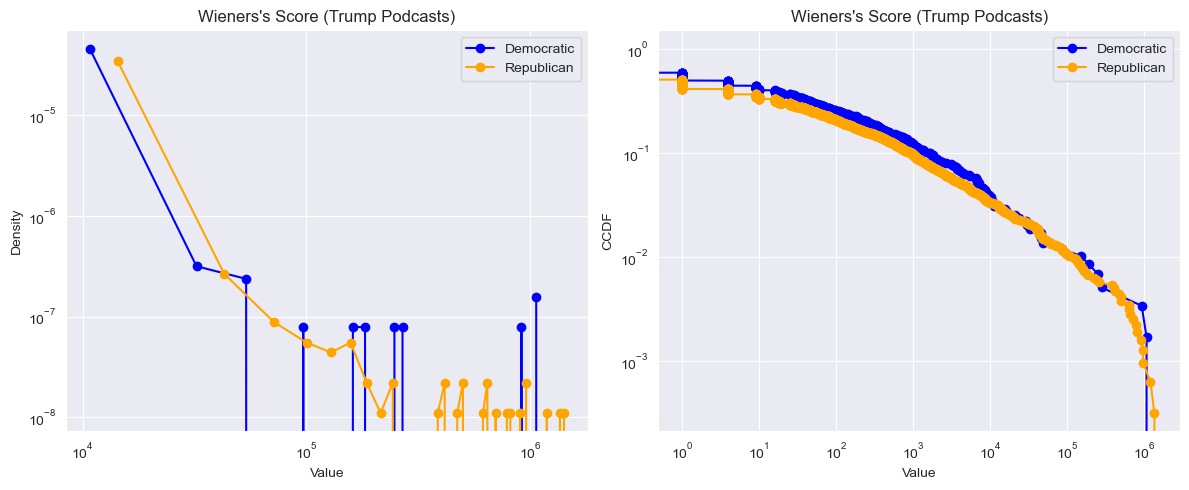

In [12]:
plot_pdf_ccdf(trump_dem_thread_wieners, trump_rep_thread_wieners, title="Wieners's Score (Trump Podcasts)", label1='Democratic', label2='Republican')

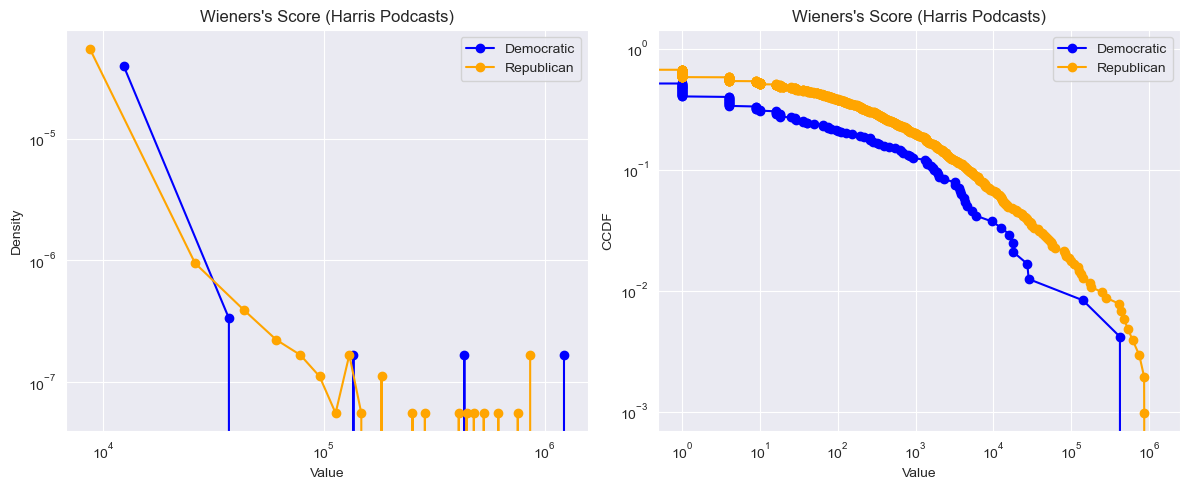

In [13]:
plot_pdf_ccdf(harris_dem_thread_wieners, harris_rep_thread_wieners, title="Wieners's Score (Harris Podcasts)", label1='Democratic', label2='Republican')

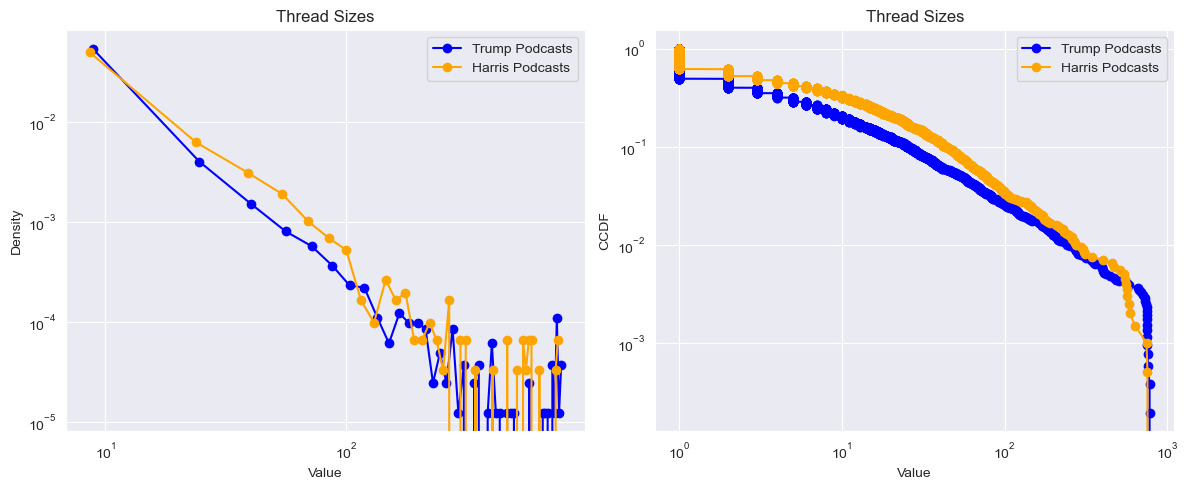

In [14]:
plot_pdf_ccdf(trump_thread_sizes, harris_thread_sizes, title="Thread Sizes", label1='Trump Podcasts', label2='Harris Podcasts')

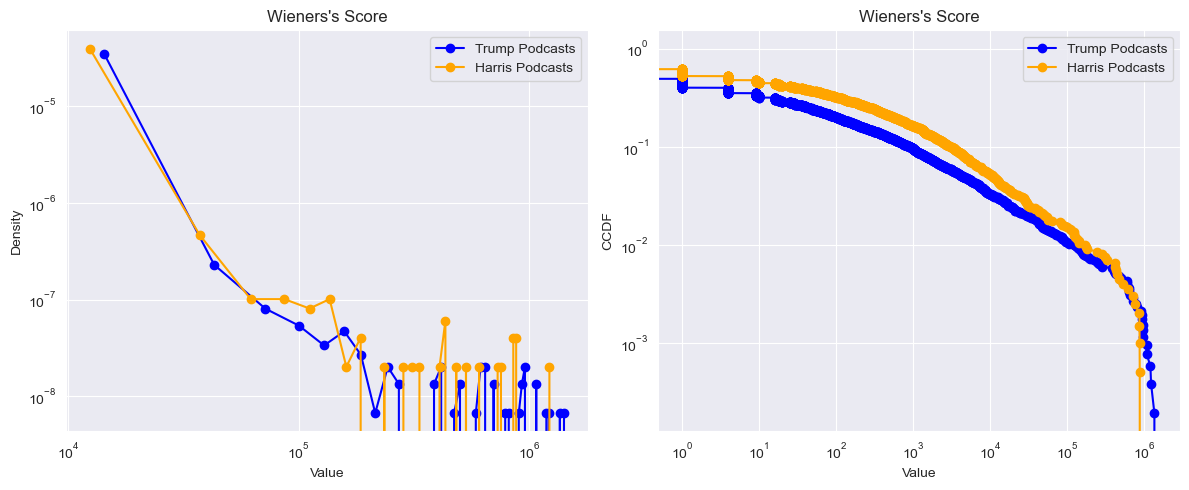

In [15]:
plot_pdf_ccdf(trump_thread_wieners, harris_thread_wieners, title="Wieners's Score", label1='Trump Podcasts', label2='Harris Podcasts')

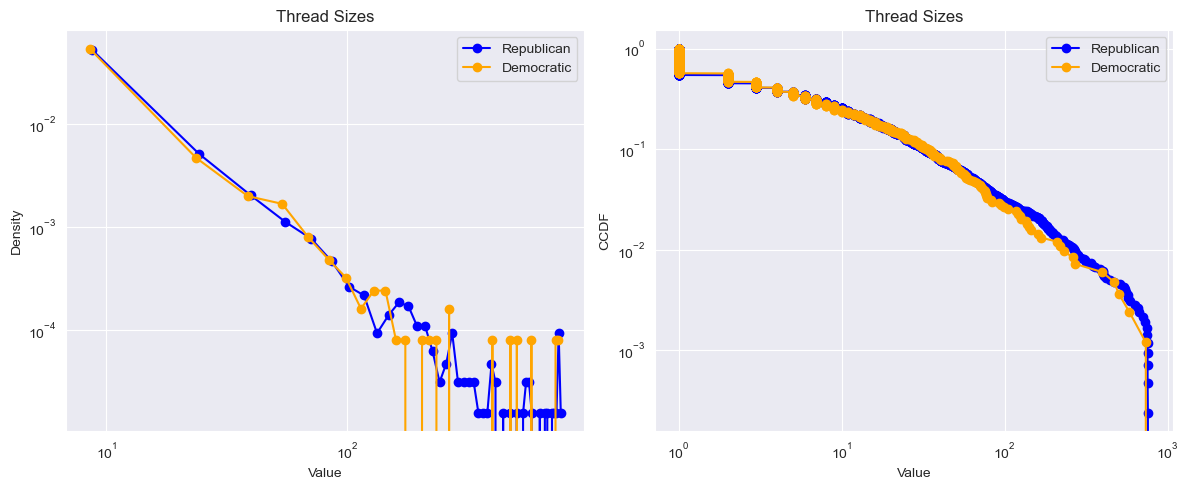

In [16]:
plot_pdf_ccdf(rep_thread_sizes, dem_thread_sizes, title="Thread Sizes", label1='Republican', label2='Democratic')

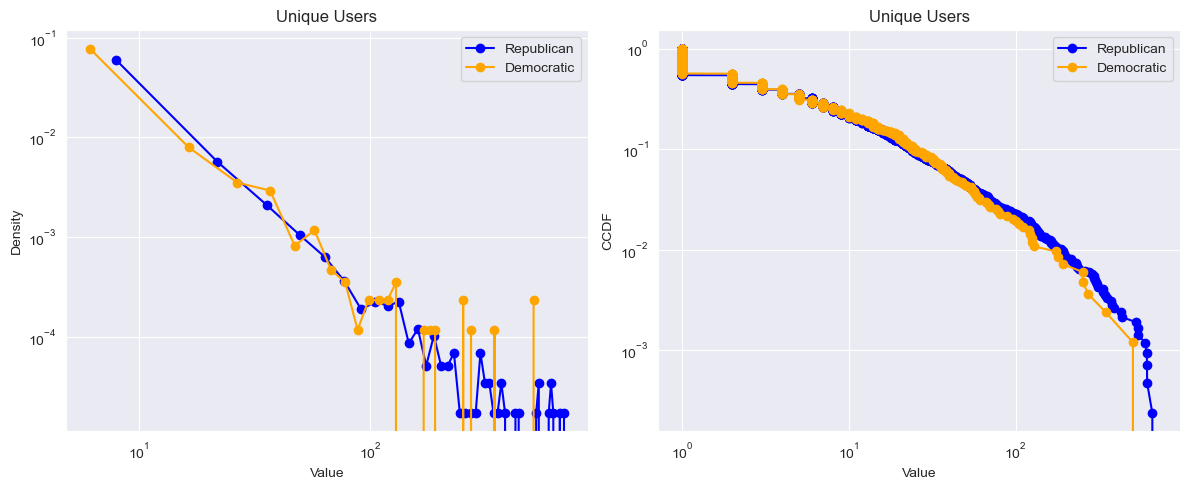

In [17]:
plot_pdf_ccdf(rep_thread_unique_users, dem_thread_unique_users, title="Unique Users", label1='Republican', label2='Democratic')

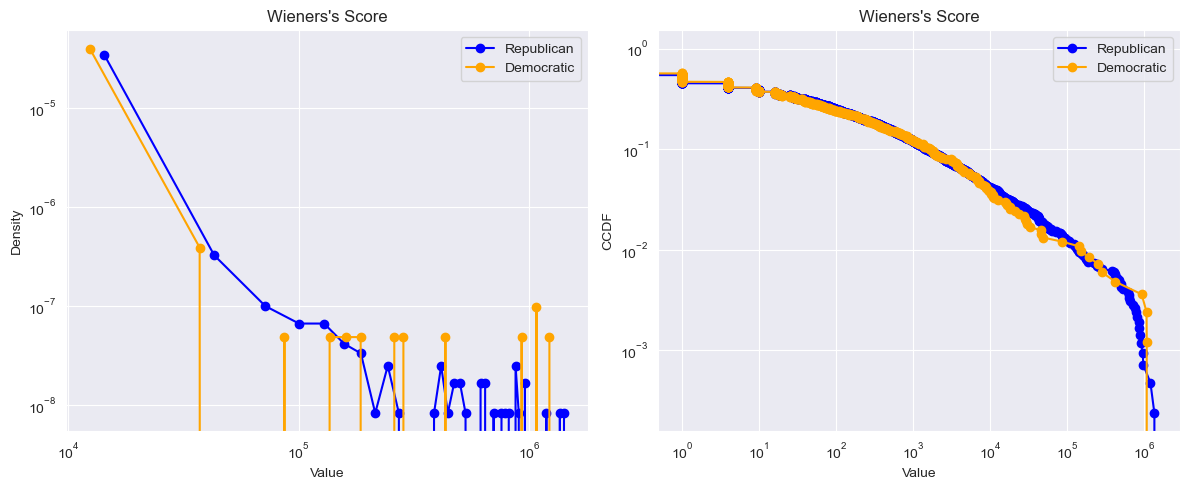

In [18]:
plot_pdf_ccdf(rep_thread_wieners, dem_thread_wieners, title="Wieners's Score", label1='Republican', label2='Democratic')

In [9]:
def is_cross_partisan(branch : list[youtube.YTComment]) -> bool:
    if not branch: return False
    stances = [user_stance.get(comment.author.id, 0) for comment in branch]
    return any(s > 0 for s in stances) and any(s < 0 for s in stances) # At least on > 0 and one < 0

In [10]:
all_branches = [
    branch
    for thread in yt_threads
    for branch in thread.get_branches()
]

cross_partisan_branches = [
    branch
    for branch in all_branches
    if is_cross_partisan(branch)
]

print(f"Total Branches are {len(all_branches)}")
print(f"Cross Partisan: {len(cross_partisan_branches)} ({len(cross_partisan_branches)/len(all_branches)*100:.2f}%)")

Total Branches are 90570
Cross Partisan: 22657 (25.02%)


In [11]:
# Filter branches to analyze only the best
filtered_branches = [
    branch
    for branch in all_branches
    if len(branch) >= 4
       and len(branch) / len(set([comment.author.id for comment in branch])) > 1.3
] # At least 4 comments, average of > 1.5 comment per user

filtered_cross_partisan_branches = [branch for branch in filtered_branches if is_cross_partisan(branch)]

filtered_non_cross_partisan_branches = [branch for branch in filtered_branches if not is_cross_partisan(branch)]

filtered_trump_branches = [branch for branch in filtered_branches if branch[0].video_id in trump_podcasts]

filtered_harris_branches = [branch for branch in filtered_branches if branch[0].video_id in harris_podcasts]

branch_by_id = {
    branch_id: branch
    for branch_id, branch in enumerate(filtered_branches)
}

print(f"Filtered: {len(filtered_branches)}")
print(f"Cross Partisan Filtered: {len(filtered_cross_partisan_branches)}")
print(f"Non Cross Partisan Filtered: {len(filtered_non_cross_partisan_branches)}")
print(f"Trump Filtered: {len(filtered_trump_branches)}")
print(f"Harris Filtered: {len(filtered_harris_branches)}")

Filtered: 4627
Cross Partisan Filtered: 2821
Non Cross Partisan Filtered: 1806
Trump Filtered: 2833
Harris Filtered: 1794


In [12]:
branch = filtered_cross_partisan_branches[164]
for comment in branch:
    print(f"{comment.author.display_name}: {comment.content} ({user_stance.get(comment.author.id)})")

@ESPLTD322: Shadow banning WON’T stop us all voting on November 5th. MAGA 🇺🇸 (1.0)
@petershaw6346: If he didn't make it great the first time around he isn't going to do it if he gets back in (-0.1111111111111111)
@ashtonsmith1905: @@petershaw6346how old were u when trump was in office😂 12? (0.0)
@petershaw6346: @@ashtonsmith1905 what did Trump do for the American people? (-0.1111111111111111)
@FreeThinker0: @petershaw6346  at least things were stable while he was in the office. (0.5)
@petershaw6346: @@FreeThinker0 what was stable? (-0.1111111111111111)
@FreeThinker0: @@petershaw6346 a few of those are the prices for gas and goods, interest rate, and relationship with foreign countries. (0.5)
@petershaw6346: @@FreeThinker0 Putin's unjustifiable invasion of Ukraine is why everything is expensive that's why central banks in almost every country has raised interest rates (-0.1111111111111111)
@zblicky2573: @@petershaw6346 lol if you do your own research like most newer republicans do you c

In [13]:
branch = filtered_non_cross_partisan_branches[164]
for comment in branch:
    print(f"{comment.author.display_name}: {comment.content} ({user_stance.get(comment.author.id)})")

@bencharlie9509: The President now has an EV! He’s always said he’s not against EVs, he wants us to have a choice not be told we have to buy them. (1.0)
@diesel2464: Whats the meaning of EV ? (0.0)
@canadiangoose7665: @@diesel2464electric vehicle (0.0)
@diesel2464: @@canadiangoose7665 a scholar and a gentleman. Thanks (0.0)


In [40]:
# Now that numbers are reduced by a lot, we can:
# - Run Perspective API on each comment, for toxicity score
# - Run an LLM to extract:
#    1. Topics ("Summarize this conversation with 3–5 concise topic keywords or phrases.")
#    2. Outcome ("Did the conversation end in agreement, disagreement, or inconclusive?")

In [14]:
print(sum([len(branch) for branch in filtered_branches])) # 34k total comments

33925


In [ ]:
def get_branch_toxicity(branch : list[youtube.YTComment]) -> float:
    scores = list()
    for comment in branch:
        score = text_classifier.get_toxicity_score(comment.content)
        if score:
            scores.append(score)
        #print(f"Result for {comment.content} is {score}")
        time.sleep(0.98)
    if len(scores) == 0: return 0
    return sum(scores) / len(scores)

branch_toxicities = dict()

# Open file in append mode so you can resume if needed
with open("branch_toxicities.csv", mode="a", newline="", encoding="utf-8") as f:
    writer = csv.writer(f)
    # Optionally write header if file is empty
    f.seek(0, 2)
    if f.tell() == 0:
        writer.writerow(["branch_id", "toxicity"])

    for idx, branch in branch_by_id.items():
        if idx < 2680: continue
        toxicity = get_branch_toxicity(branch)
        branch_toxicities[idx] = toxicity
        print(f"{idx}/{len(branch_by_id)} - Toxicity is {toxicity:.2f}", flush=True)
        writer.writerow([idx, f"{toxicity:.4f}"])
        f.flush()


In [126]:
def branch_to_string(branch : list[youtube.YTComment]) -> str:
    result = ""
    for comment in branch:
        result += f"{comment.author.display_name}: {comment.content}"
    return result

# Open file in append mode so you can resume if needed
with open("branch_topics_ending.csv", mode="a", newline="", encoding="utf-8") as f:
    writer = csv.writer(f)
    # Optionally write header if file is empty
    f.seek(0, 2)
    if f.tell() == 0:
        writer.writerow(["branch_id", "topics", "ending"])

    for idx, branch in branch_by_id.items():
        if idx < 4404: continue
        json_response = text_classifier.get_gemini_discussion_analysis(branch_to_string(branch))
        print(idx, json_response)
        topics = " - ".join(json_response["topics"])
        ending = json_response["ending"]
        writer.writerow([idx, topics, ending])
        f.flush()

4404 {'topics': ['comment section viewership', 'mutual acknowledgement', 'dislike button'], 'ending': 'inconclusive'}
4405 {'topics': ["Kamala Harris's communication style", 'Presidential election', 'media bias'], 'ending': 'agreement'}
4406 {'topics': ['comment section viewership', 'call to action (dislike/comment)', 'shared experience'], 'ending': 'inconclusive'}
4407 {'topics': ["Harris's potential votes", 'Viewer count vs likes', 'Personal insults'], 'ending': 'disagreement'}
4408 {'topics': ['low video watch time', 'Kamala Harris support', 'projected election outcome', 'past election results'], 'ending': 'disagreement'}
4409 {'topics': ['election predictions', 'Kamala Harris support', 'MAGA trolling'], 'ending': 'disagreement'}
4410 {'topics': ['voter behavior', 'election outcome prediction', "Trump's economic promises"], 'ending': 'disagreement'}
4411 {'topics': ['low watch time', 'Kamala Harris supporters vs MAGA', 'election outcome prediction', 'state of America'], 'ending': 'd